In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import traceback
import string
import scorecardpy as sc
import mlxtend

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

In [3]:
train = pd.read_csv('./dataset/train.csv')
train.head(2)

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0


In [4]:
train["credit_card_default"].value_counts(normalize=True)

credit_card_default
0    0.918797
1    0.081203
Name: proportion, dtype: float64

In [5]:
df = train.sample(n = 30000, random_state = 42, replace = False)
df.head(3)

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
34126,CST_163708,Wachtel,50,F,N,Y,0.0,269502.14,4181.0,Unknown,1.0,0.0,17440.44,36017.45,23,807.0,0,0,0
44609,CST_131305,Deepa,29,F,N,Y,0.0,115795.25,365250.0,Unknown,2.0,0.0,28962.21,21781.38,60,858.0,0,0,0
44264,CST_131350,Jason,39,F,N,Y,0.0,113477.67,365241.0,Unknown,2.0,0.0,27463.96,27485.15,81,667.0,0,0,1


In [6]:
df["credit_card_default"].value_counts()
df["credit_card_default"].value_counts(normalize=True)

credit_card_default
0    0.9179
1    0.0821
Name: proportion, dtype: float64

In [7]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 34126 to 33325
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              30000 non-null  object 
 1   name                     30000 non-null  object 
 2   age                      30000 non-null  int64  
 3   gender                   30000 non-null  object 
 4   owns_car                 29631 non-null  object 
 5   owns_house               30000 non-null  object 
 6   no_of_children           29498 non-null  float64
 7   net_yearly_income        30000 non-null  float64
 8   no_of_days_employed      29685 non-null  float64
 9   occupation_type          30000 non-null  object 
 10  total_family_members     29944 non-null  float64
 11  migrant_worker           29947 non-null  float64
 12  yearly_debt_payments     29938 non-null  float64
 13  credit_limit             30000 non-null  float64
 14  credit_limit_used(%)   

In [8]:
cat_feats = [col for col in df.columns if df[col].dtypes == "object"]
num_feats =  [col for col in df.columns if df[col].dtypes != "object"]

print("no of cat feats: ", len(cat_feats))
print("no of num feats: ", len(num_feats))

no of cat feats:  6
no of num feats:  13


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isnull().sum().sort_values(ascending=False).head(8)

no_of_children          502
owns_car                369
no_of_days_employed     315
yearly_debt_payments     62
total_family_members     56
migrant_worker           53
credit_score              6
age                       0
dtype: int64

In [11]:
df['gender'].value_counts()

gender
F      19731
M      10268
XNA        1
Name: count, dtype: int64

In [12]:
df[df['gender'] == 'XNA']

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
28498,CST_144669,ernard,52,XNA,N,Y,2.0,203596.95,2806.0,Low-skill Laborers,4.0,0.0,14700.2,65487.34,40,669.0,0,0,0


In [13]:
df['gender'] = df['gender'].apply(lambda x: 'M' if x=='XNA' else x)
df['gender'].value_counts()

gender
F    19731
M    10269
Name: count, dtype: int64

In [16]:
df["owns_car"].value_counts(normalize=True)

owns_car
N    0.660862
Y    0.339138
Name: proportion, dtype: float64

In [14]:
df['owns_car'] = df['owns_car'].fillna(df['owns_car'].mode()[0])
df["owns_car"].value_counts(normalize=True)

owns_car
N    0.665033
Y    0.334967
Name: proportion, dtype: float64

In [15]:
# impute 'no_of_days_employed' with median based on 'occupation_type'
occp_days_employed = df.groupby(by='occupation_type')['no_of_days_employed'].median()
occp_days_employed

occupation_type
Accountants                1828.0
Cleaning staff             1462.0
Cooking staff              1360.0
Core staff                 1858.0
Drivers                    1338.5
HR staff                   1467.0
High skill tech staff      1728.0
IT staff                   1601.0
Laborers                   1682.5
Low-skill Laborers          984.0
Managers                   2128.0
Medicine staff             2924.0
Private service staff      1655.0
Realty agents              1383.0
Sales staff                1277.5
Secretaries                1678.0
Security staff             1393.5
Unknown                  365241.0
Waiters/barmen staff       1339.5
Name: no_of_days_employed, dtype: float64

In [16]:

for i in occp_days_employed.index:
    df['no_of_days_employed'] = np.where((df['no_of_days_employed'].isna()) & (df['occupation_type'] == i), occp_days_employed[i], df['no_of_days_employed'])

In [17]:
df.no_of_days_employed.isna().sum()

np.int64(0)

In [18]:
# impute 'yearly_debt_payments' with median based on 'credit_card_default'
yearDebt_credit = df.groupby(by='credit_card_default')['yearly_debt_payments'].median()
for i in yearDebt_credit.index:
    df['yearly_debt_payments'] = np.where((df['yearly_debt_payments'].isna()) & (df['credit_card_default'] == i), yearDebt_credit[i], df['yearly_debt_payments'])

In [19]:
df.yearly_debt_payments.isna().sum()

np.int64(0)

In [20]:
df['migrant_worker'] = df['migrant_worker'].fillna(df['migrant_worker'].mode()[0])
# check null values count
df['migrant_worker'].isna().sum()

np.int64(0)

In [21]:
df['total_family_members'] = df['total_family_members'].fillna(df['total_family_members'].mode()[0])
# check null values count
df['total_family_members'].isna().sum()

np.int64(0)

In [22]:
# fill no_of_children with mode of the data
df['no_of_children'] = df['no_of_children'].fillna(df['no_of_children'].mode()[0])

In [23]:
# check medians of credit_score wrt credit_card_default
cred_score = df.groupby(by='credit_card_default')['credit_score'].median()

for i in cred_score.index:
    df['credit_score'] = np.where((df['credit_score'].isna()) & (df['credit_card_default'] == i), cred_score[i], df['credit_score'])

# check for null values in 'credit_score'
df['credit_score'].isna().sum()

np.int64(0)

In [24]:
df[num_feats].isnull().sum().sort_values(ascending = False)

age                        0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

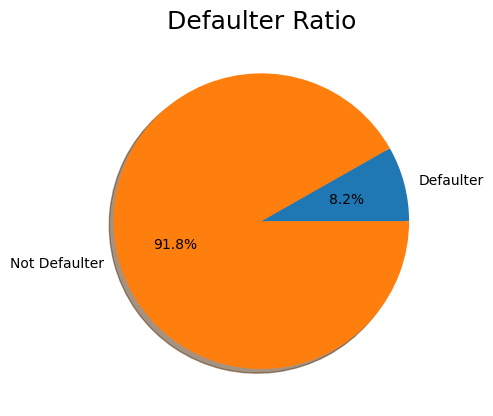

In [25]:
# Ploting Credit_default ratio
total_default_values = df.credit_card_default.value_counts(ascending=True).values

plt.figure()
plt.pie(total_default_values, labels=['Defaulter', 'Not Defaulter'], autopct='%1.1f%%', shadow=True)
plt.title('Defaulter Ratio', fontsize=18)
plt.show()

C:\Users\rudhv\AppData\Local\Temp\ipykernel_15684\415801257.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


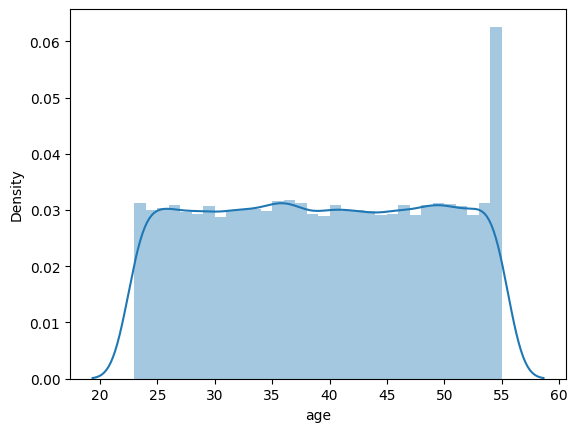

In [30]:
# visualize AGE feature - distplot
plt.figure()
sns.distplot(df['age'])
# sns.histplot(df['age'], kde=True)
plt.show()

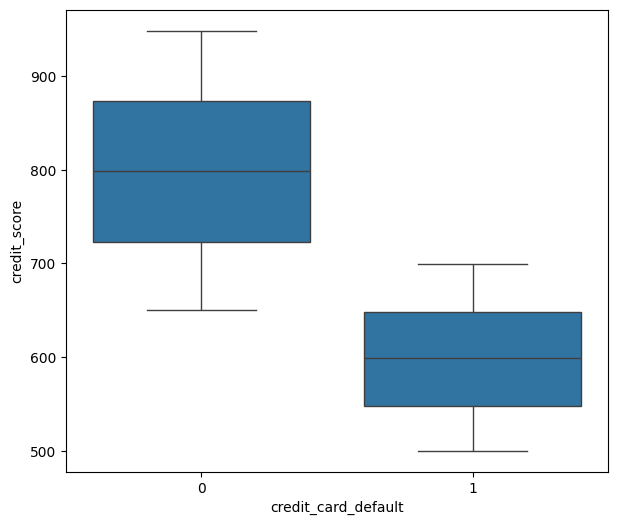

In [32]:
plt.figure(figsize=[7,6])
sns.boxplot(x=df['credit_card_default'], y=df['credit_score'])
plt.show()


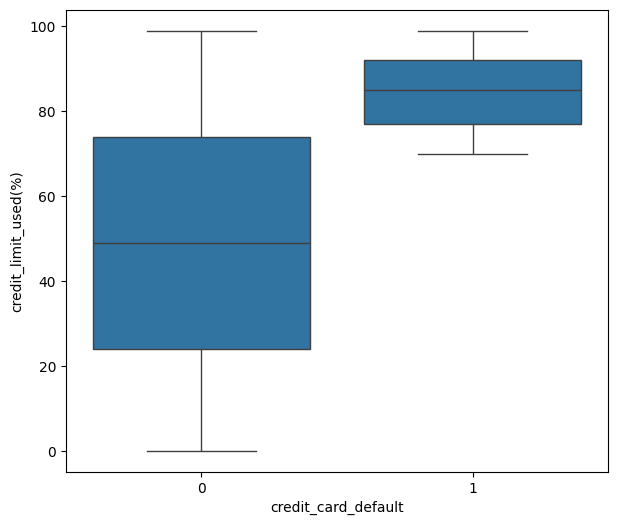

In [33]:
# boxplot of credit_defaulter-credit_limit_utilization
plt.figure(figsize=[7,6])
sns.boxplot(x=df['credit_card_default'], y=df['credit_limit_used(%)'])
plt.show()

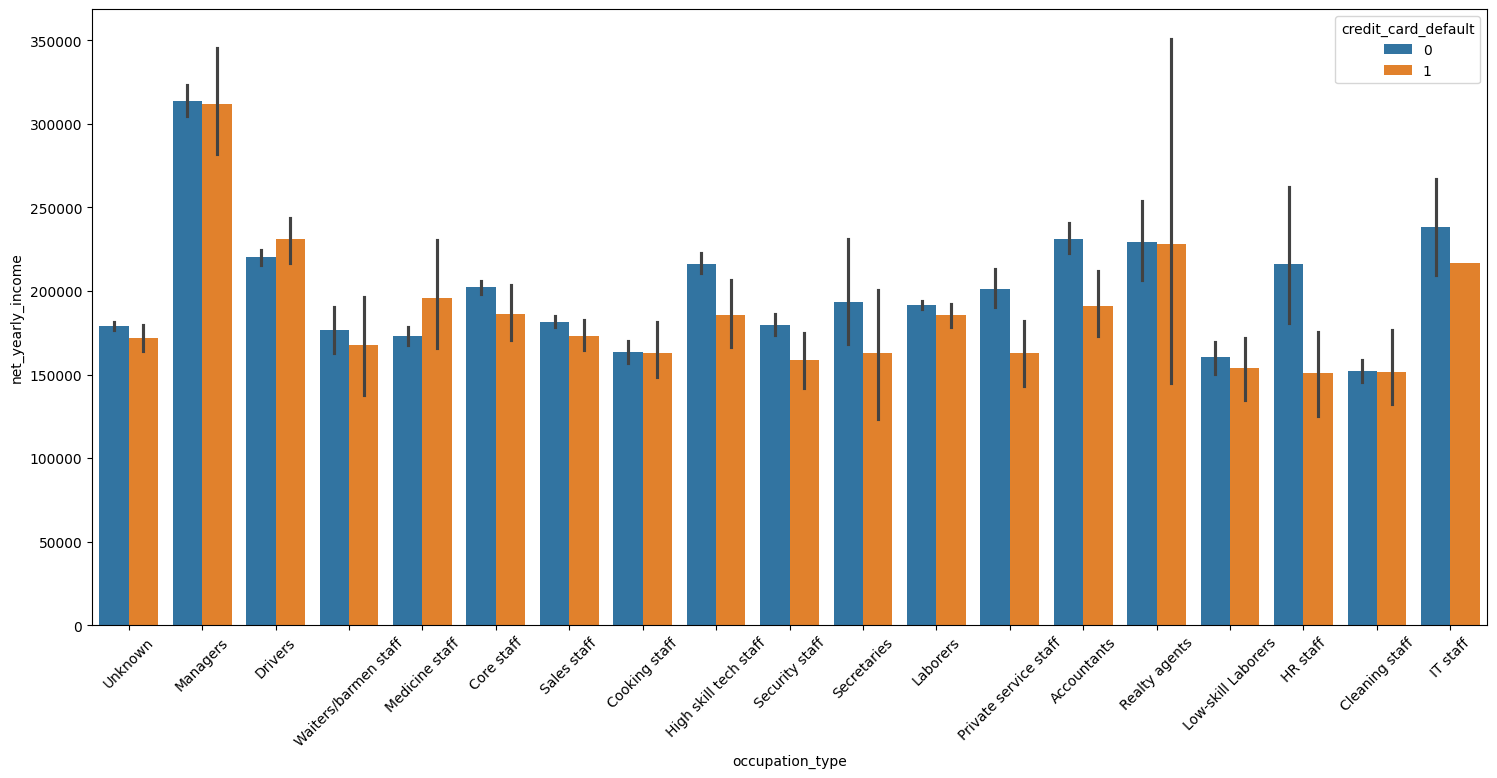

In [34]:
# barplots for occupation types wrt credit_default
plt.figure(figsize=[18,8])
sns.barplot(x=df['occupation_type'], y=df['net_yearly_income'], hue=df['credit_card_default'])
plt.xticks(rotation=45)
plt.show()

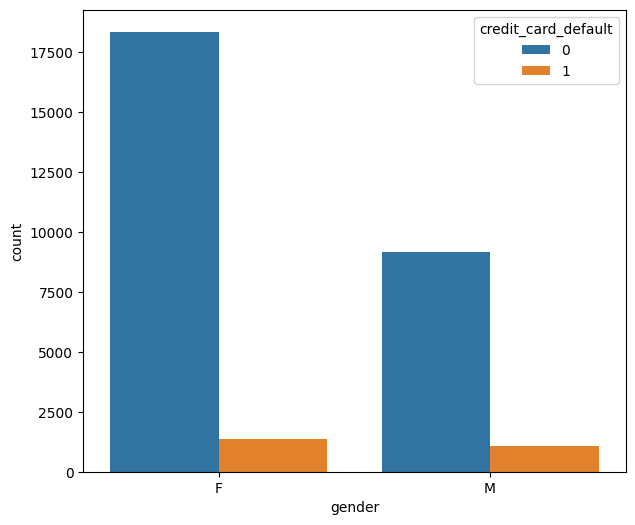

In [36]:
plt.figure(figsize=[7,6])
sns.countplot(x="gender", hue="credit_card_default", data=df)
plt.show()

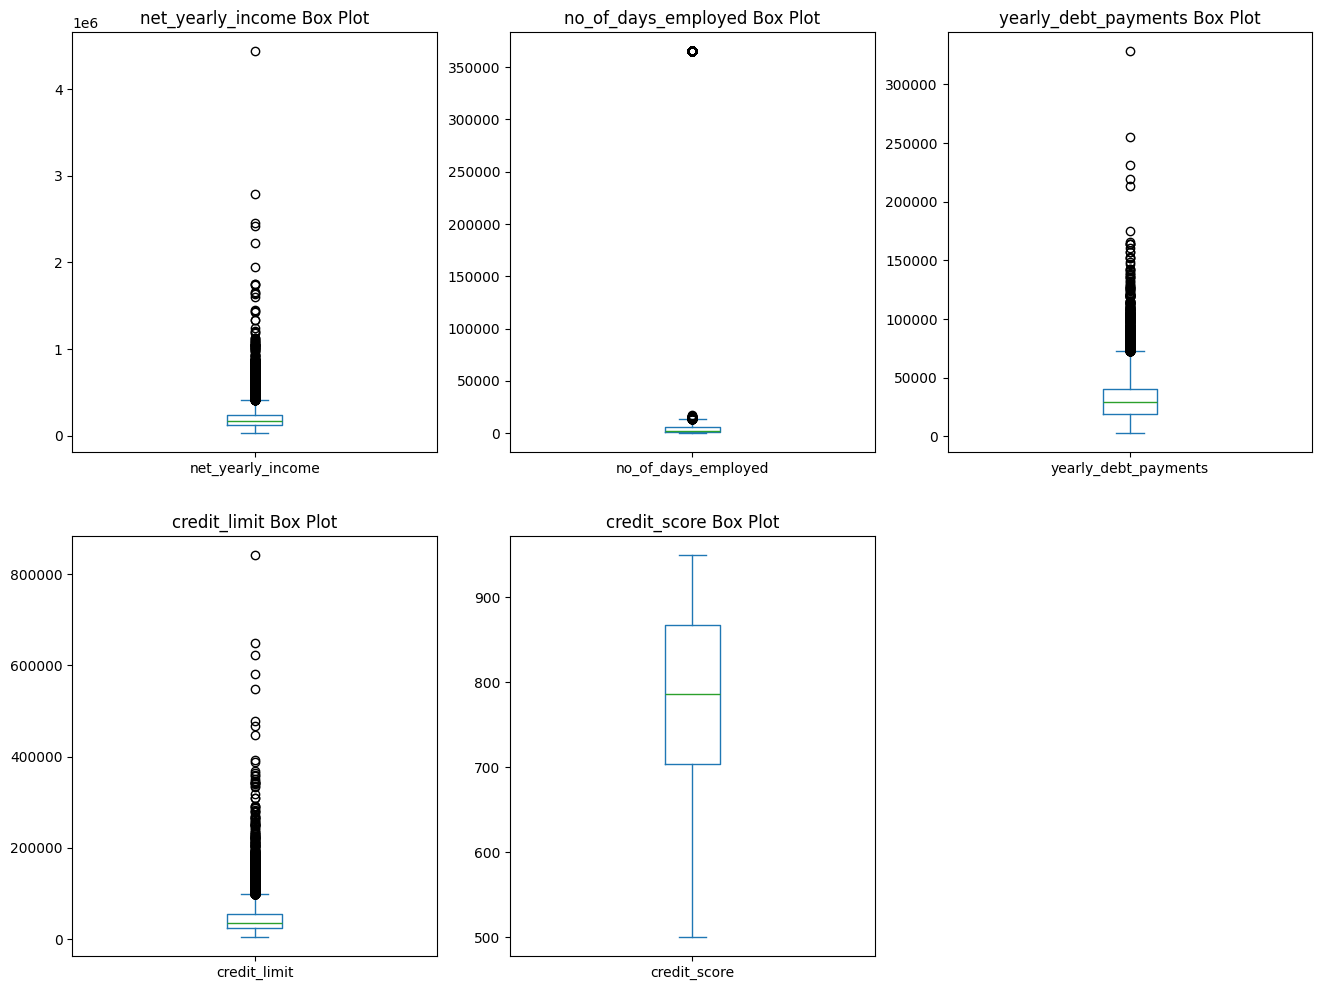

In [37]:
# boxplot of all continuous variables

plt.figure(figsize=[16, 12])
plt.subplot(2,3,1)
df['net_yearly_income'].plot.box()
plt.title('net_yearly_income Box Plot')

plt.subplot(2,3,2)
df['no_of_days_employed'].plot.box()
plt.title('no_of_days_employed Box Plot')

plt.subplot(2,3,3)
df['yearly_debt_payments'].plot.box()
plt.title('yearly_debt_payments Box Plot')

plt.subplot(2,3,4)
df['credit_limit'].plot.box()
plt.title('credit_limit Box Plot')

plt.subplot(2,3,5)
df['credit_score'].plot.box()
plt.title('credit_score Box Plot')
plt.show()